# Analysis

The following notebook prepares a minimal analysis that studies the log file 

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Load and prepare the data

Before running the analysis the log file, by default named **ips.log** schould be copied locally, from the monitoring machine.

The file is a simple CSV file, read using Pandas, forcing both column as strings. Later the IP string is converted as integer,
to avoid some issues when comparing strings in pandas, and the timestamp string is properly converted as datetime and promoted
as index.

In [16]:
df = pd.read_csv("ips.log", header=None, names=["Time", "IP"], dtype="string")

In [17]:
def numericIP(ipstr):
    """
    Convert the string representing the IP as integer. In case
    the string doesn't seem compatible with an IP the value -1
    is returned.
    """
    if not isinstance(ipstr, str):
        return -1
    els  = ipstr.split(".")
    v = 0
    if len(els)==4:
        for iel, el in enumerate(els):
            v  |= int(el)<<(8*iel)
    else:
        v = -1
    return v

In [18]:
# add a column using the numeric representation of the IP column
df["IPnum"] = df["IP"].apply(numericIP)

In [19]:
# convert the Time column to the datetime format.
df["Time"] = pd.to_datetime(df["Time"])

In [20]:
# use Time as index to simplify the following time analysis
df = df.set_index("Time")

## Number of disconnessions

The most simple quantity to analyse is the number of disconnessione that occourred overtime. To derive this
we exploit how the script extract that public IP of the connection, this reassigned to the modem every time it
is rebooted or the synchronization is lost. 

A rolling window function, checking if the IP changes between to consecutive logs is used. The first value is
not usable.

In [21]:
changeS = df["IPnum"].rolling(window=2).apply(lambda x: x[0]!=x[1]).dropna()

We can then extract, resampling the date in example by hour, the number of time the connestion was lost.
The number represents a lower limit for the number of disconnection experienced by the system, e.g:
scheduling the monitoring script to run every 10 minutes can measure at most 6 reconnections.

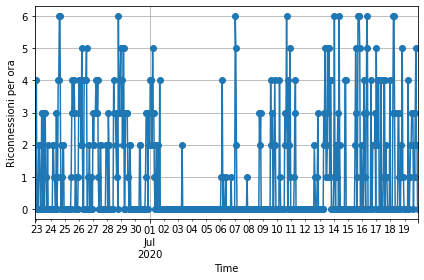

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure()
pdata = changeS.resample("1h").sum()
pdata.plot(style="o-")

plt.grid()
plt.ylabel("Riconnessioni per ora")
plt.tight_layout()
plt.show()
plt.savefig("Riconnessioni.png")

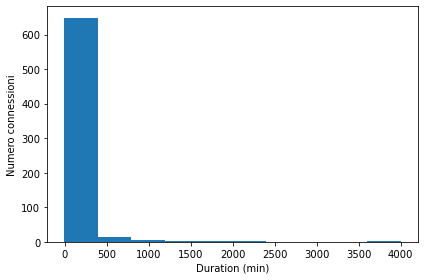

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure()
x = np.diff(changeS[changeS>0].index.values)/np.timedelta64(1, "m")
hx = plt.hist(x)
plt.xlabel("Duration (min)")
plt.ylabel("Numero connessioni")
plt.tight_layout()
plt.show()
plt.savefig("durata.png")

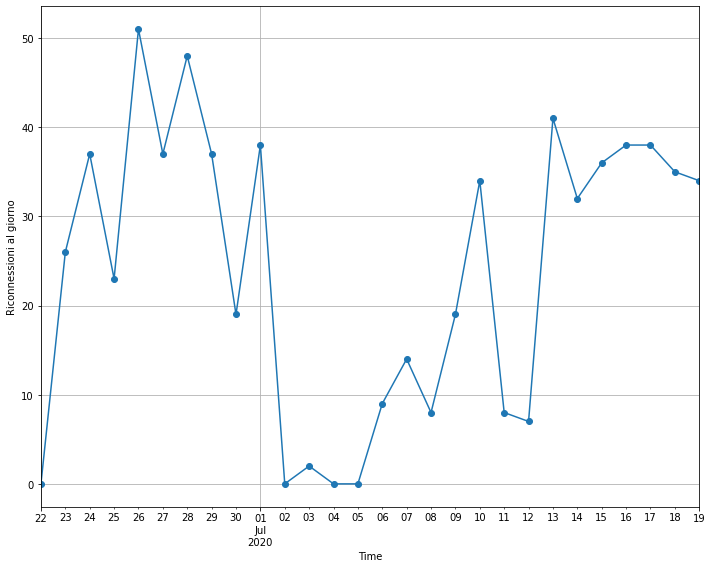

In [24]:
plt.figure(figsize=(10,8))
pdata = changeS.resample("1d").sum()
pdata.plot(style="o-")

plt.grid()
plt.ylabel("Riconnessioni al giorno")
plt.tight_layout()
plt.savefig("Riconnessioni_daily.png")
plt.show()

In [25]:
pdata.tail()

Time
2020-07-15    36.0
2020-07-16    38.0
2020-07-17    38.0
2020-07-18    35.0
2020-07-19    34.0
Freq: D, Name: IPnum, dtype: float64